# Stock Trades by Members of the US House of Representatives

This project uses public data about the stock trades made by members of the US House of Representatives. This data is collected and maintained by Timothy Carambat as part of the [House Stock Watcher](https://housestockwatcher.com/) project. The project describes itself as follows:

> With recent and ongoing investigations of incumbent congressional members being investigated for potentially violating the STOCK act. This website compiles this publicly available information in a format that is easier to digest then the original PDF source.
>
> Members of Congress must report periodic reports of their asset transactions. This website is purely for an informative purpose and aid in transparency.
>
> This site does not manipluate or censor any of the information from the original source. All data is transcribed by our community of contributors, which you can join for free by going to our transcription tool. Our moderation team takes great care in ensuring the accuracy of the information.
>
> This site is built and maintained by Timothy Carambat and supported with our contributors.

### Getting the Data

The full data set of stock trade disclosures is available as a CSV or as JSON at https://housestockwatcher.com/api.

This data set does not, however, contain the political affiliation of the congresspeople. If you wish to investigate a question that relies on having this information, you'll need to find another dataset that contains it and perform a merge. *Hint*: Kaggle is a useful source of data sets.


### Cleaning and EDA

- Clean the data.
    - Certain fields have "missing" data that isn't labeled as missing. For example, there are fields with the value "--." Do some exploration to find those values and convert them to null values.
    - You may also want to clean up the date columns to enable time-series exploration.
- Understand the data in ways relevant to your question using univariate and bivariate analysis of the data as well as aggregations.


### Assessment of Missingness

- Assess the missingness per the requirements in `project03.ipynb`

### Hypothesis Test / Permutation Test
Find a hypothesis test or permutation test to perform. You can use the questions at the top of the notebook for inspiration.

# Summary of Findings

### Introduction
We want to explore whether the political affiliation of the congresspeople will influence their stock trade amount. Therefore, we mainly utilize two datasets to answer this question. The first dataset includes the congresspeople's names, the ticker of their trade, the transaction date and so on. We mainly focus on each year's congresspeople's name and their trade amount each day. The second dataset comes from the Kaggle, which includes political affiliations corresponding to each of the congresspeople. We merge these two datasets and then find their underlying relationship.

### Cleaning and EDA
TODO

### Assessment of Missingness
We first determined which values were missing. There are two types of missing in the dataframe: "None" and "--". We turn all of the missing values into NaN. These missing values are from Ticker, owner, and asset_description columns. Since asset_description only missing five rows, so we should have paid more attention to it. We mainly focus on examining the reason for Ticker's missing. We did the permutation test for tickers with all of the columns in the dataframe. We find that all of the p-values are more than the significance level of 5%. We fail to reject the null hypothesis of the missingness of Ticker depending on other columns. Then we calculate the average amount of trade and generate new columns. We used the average amount and missingness of the Ticker to do the permutation test. The p-value is 0, which is less than the significance level of 5%. Therefore, we can infer that the missingness of Ticker is related to the trade amount, and this is MAR missingness.

### Hypothesis Test
Our null hypothesis is party and trade amount are not related – the high average trade amount of the democratic party is due to chance alone. Our alternative hypothesis is party and trade amount is related  – the high average trade amount of the democratic party is not due to chance alone. We choose the mean average of democratic trade amount as the test statistic. Since if the party and trade amount are not related, we randomly pick the same amount of democratic party people from the population and calculate their average, we will get a similar average amount as we calculate the mean of the democratic trade amount. We repeated the experiment and found the final p-value was 0.771. we choose the significance level of 5% because this is the strict level of significance, and we want to avoid a false positive rate. Since the p-value is 0.771, which is bigger than 0.05, we fail to reject the null hypothesis. Therefore, the party and the trade amount are not related.

# Code

In [233]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [234]:
import glob
import time
import requests
import bs4
\
import lxml

### Cleaning and EDA

In [235]:
# We obtain the data from the website and use requests to get the API. use json to read in the data and convert it into the dataframe
r = requests.get('https://house-stock-watcher-data.s3-us-west-2.amazonaws.com/data/all_transactions.json')
stock = pd.DataFrame(r.json())
stock.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False


- Because we want to investigate stock trading behavior between political parties, we try to find another dataframe that contains the political affiliation data for the house of representatives. The dataframe we used is from: 
https://www.kaggle.com/datasets/aavigan/house-of-representatives-congress-116/versions/4/code

In [236]:
# import the data, and takes in the two columns that we need (the name of the representatives and their current party)
affiliation = pd.read_csv("house_members_116.csv")
affiliate = affiliation[['name', 'current_party']]
affiliate

,name,current_party
0,ralph-abraham,Republican
1,alma-adams,Democratic
2,robert-aderholt,Republican
3,pete-aguilar,Democratic
4,rick-allen,Republican
...,...,...
438,ron-wright,Republican
439,john-yarmuth,Democratic
440,ted-yoho,Republican
441,don-young,Republican


The names column in the affiliate dataframe has different format to the representatives column in the stock-watcher dataframe. Therefore we start the cleaning process. 

In [237]:
# Start by replacing the hyphen in name column into space
affiliate = affiliate.assign(name = affiliate['name'].str.replace('-', ' '))

In [238]:
affiliate

,name,current_party
0,ralph abraham,Republican
1,alma adams,Democratic
2,robert aderholt,Republican
3,pete aguilar,Democratic
4,rick allen,Republican
...,...,...
438,ron wright,Republican
439,john yarmuth,Democratic
440,ted yoho,Republican
441,don young,Republican


In [239]:
# The representatives column in stock dataframe contains different titles before the name, and include middle names; where as
# the name in the affiliate dataframe mostly have only first and last name in all lower cases. Therefore we create a function to 
# convert them both to same format: lower case with only first and last name.
def clean_name(name):
    name = name.replace('Hon. ', '')
    name = name.replace('None ', '')
    name = name.replace('Mr. ', '')
    name = name.replace('Mrs. ', '')
    name = name.replace('W. ', '')
    no_middle = name.split(' ')[0] +' ' + name.split(' ')[-1]
    return no_middle.lower()


In [240]:
# apply the clean_name method on both columns
affiliate['name'] = affiliate['name'].transform(clean_name)
stock['cleaned_name'] = stock['representative'].transform(clean_name)

In [241]:
# Also, by examine the data, we found names written in different formats in the two dataframes. Convert the name column in affiliate
# dataframe to match the representatives. 
replace_values = {
           'rick allen': 'richard allen',
           'cynthia axne': 'cindy axne',
           'dan crenshaw': 'daniel crenshaw',
           'gregory murphy': 'greg murphy',
            'w steube': 'greg steube',
           'jim costa': 'james costa',
           'ro khanna': 'rohit khanna',
           'mike gallagher': 'michael gallagher',
           'k conaway': 'k. conaway',
           'a mceachin': 'aston mceachin',
           'ken buck': 'kenneth buck',
           'jim banks': 'james banks',
           'j hill':'james hill',
           'raul grijalva': 'raúl grijalva',
           'mario balart': 'mario diaz-balart',
           'jim hagedorn':'james hagedorn',
           'raja krishnamoorthi': 's. krishnamoorthi',
           'wm clay': 'wm. clay',
           'tom halleran': "tom o'halleran",
          }

affiliate['name'].replace(replace_values, inplace=True)

**We are now done with the first step of cleaning the names. Now try to merge the two dataframes on representatives and name. Since we want to keep all the rows on the stock data, we choose left join.**

In [242]:
with_party = stock.merge(affiliate, left_on = 'cleaned_name', right_on = 'name', how='left')
with_party.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,cleaned_name,name,current_party
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,virginia foxx,Republican
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,virginia foxx,Republican
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,virginia foxx,Republican
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,virginia foxx,virginia foxx,Republican
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,alan lowenthal,alan lowenthal,Democratic


In [243]:
# There are 26 names that do not appear in the data we found online. We use the "summary by rep" page on the stock-watcher website
# to mannually fill out these names. Also, there is one case that two people with same first and last name belongs to different
# parties, create a special case for that.
d = 'Democratic'
r = 'Republican'
mannul_fill_party = {
                    'kathy manning': d, 'scott franklin': r,
                    'maria salazar': r, 'christopher jacobs': r,
                    'marjorie greene': r, 'bill pascrell': d,
                     'august pfluger': r, 'patrick fallon': r,
                     'pete sessions': r, 'victoria spartz': r,
                     'andrew garbarino': r,'david cawthorn': r,
                     'jake auchincloss': d, 'deborah ross': d,
                     'marie newman': d, 'blake moore': r,
                     'michael garcia': r, 'diana harshbarger': r,
                     'sara jacobs': d, 'peter meijer': r,
                     'ashley arenholz':r,'felix moore': r,
                     'stephanie bice': r, 'neal facs': r
                    }
nicholas_taylors = {"Hon. Nicholas Van Taylor": r,
                   "Hon. Nicholas V. Taylor": d}


In [244]:
# This function loops through the rows of the with_party df to check if the 'cleaned_name' or 'representative' is what we want
# to mannully fill. When found, fill in the current_party with corresponding data. 
def mannul_fill(row):
    if row['cleaned_name'] in mannul_fill_party.keys():
        return mannul_fill_party[row['cleaned_name']]
    elif row['representative'] in nicholas_taylors.keys():
        return nicholas_taylors[row['representative']]
    else:
        return row['current_party']

In [245]:
full_party = with_party.apply(mannul_fill, axis=1)
full_party.head()

0    Republican
1    Republican
2    Republican
3    Republican
4    Democratic
dtype: object

In [246]:
# now the current_party column has no missing values.
full_party.isna().sum()

0

In [247]:
with_party['current_party'] = full_party

In [248]:
with_party = with_party.drop(columns = ['cleaned_name','name'])

In [257]:
# Because we only want to investigate De
with_party = with_party[with_party["current_party"] != "Independent"]

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,current_party,avg_amount
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.0
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.0
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.0
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.0
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,8000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15705,2020,06/10/2020,2020-04-09,NaN,SWK,"Stanley Black & Decker, Inc.",sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,8000.0
15706,2020,06/10/2020,2020-04-09,NaN,USB,U.S. Bancorp,sale_partial,"$1,001 - $15,000",Hon. Ed Perlmutter,CO07,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,8000.0
15707,2020,06/10/2020,2020-03-13,NaN,BMY,Bristol-Myers Squibb Company,sale_full,"$100,001 - $250,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,Republican,175000.0
15708,2020,06/10/2020,2020-03-13,NaN,LLY,Eli Lilly and Company,sale_full,"$500,001 - $1,000,000",Hon. Nicholas Van Taylor,TX03,https://disclosures-clerk.house.gov/public_dis...,False,Republican,750000.0


In [249]:
with_party.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,current_party
0,2021,10/04/2021,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
1,2021,10/04/2021,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
2,2021,10/04/2021,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
3,2021,10/04/2021,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican
4,2021,10/04/2021,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic


### We are done with the process of entering the political affiliation for each representatives. Now lets clean the missing values in the data.

In [250]:
with_party.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15710 entries, 0 to 15709
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   disclosure_year         15710 non-null  int64 
 1   disclosure_date         15710 non-null  object
 2   transaction_date        15710 non-null  object
 3   owner                   9667 non-null   object
 4   ticker                  15710 non-null  object
 5   asset_description       15706 non-null  object
 6   type                    15710 non-null  object
 7   amount                  15710 non-null  object
 8   representative          15710 non-null  object
 9   district                15710 non-null  object
 10  ptr_link                15710 non-null  object
 11  cap_gains_over_200_usd  15710 non-null  bool  
 12  current_party           15710 non-null  object
dtypes: bool(1), int64(1), object(11)
memory usage: 1.6+ MB


In [251]:
#replace the asset_description None
with_party["asset_description"] =with_party["asset_description"].fillna(value=np.nan)

In [252]:
#replace the None owner with NaN
with_party["owner"] = with_party["owner"].fillna(value=np.nan)

In [253]:
#check missing value of dataframe and determine which columns contain "--"
for i in with_party.columns:
    if "--" in with_party[i].value_counts().index:
        print(i) 

owner
ticker


In [254]:
#replace all of -- value in the owner and ticker
with_party["owner"] = with_party["owner"].replace("--",np.nan)
with_party["ticker"] = with_party["ticker"].replace("--",np.nan)

#### We want to convert the data type of certain columns to format that is easy to calculate.
- amount to float, date to datetime

- For the amount column, we decided to take the midpoint of the amount if there is an interval(ie. for "1,001 - 15,000" we take (1001+15000)/2)=8000.5). 
- If there is only single value such as "1,001+", we take the value itself. 

In [255]:
amount = with_party['amount'].str.replace('[^0-9 ]', '', regex=True)
amount = amount.str.split('  ')

def to_float(amount):
    if len(amount) == 1:
        return float(amount[0])
    else:
        return (float(amount[0])+ float(amount[1]))//2

with_party['avg_amount'] = amount.transform(to_float)

In [256]:
amount

0            [1001, 15000]
1            [1001, 15000]
2           [15001, 50000]
3           [15001, 50000]
4            [1001, 15000]
               ...        
15705        [1001, 15000]
15706        [1001, 15000]
15707     [100001, 250000]
15708    [500001, 1000000]
15709     [250001, 500000]
Name: amount, Length: 15710, dtype: object

In [148]:
# convert the type of disclosure_date and transaction_date to datetime.
with_party['disclosure_date'] = pd.to_datetime(with_party['disclosure_date'])

In [149]:
# There are some mistyped date in the transaction_date data. Replace them with the true values and then convert to datetime.
replace_false_dates = {'0009-06-09': '2020-06-09',
                     '20222-08-09': '2022-08-09',
                      '0021-08-02': '2021-08-02',
                      '20222-07-18': '2022-07-18',
                      '20221-11-18': '2021-11-18',
                      '0021-06-22': '2021-06-22',
                      '0201-06-22': '2021-06-22'
                     }
with_party['transaction_date'].replace(replace_false_dates, inplace=True)
with_party['transaction_date'] = pd.to_datetime(with_party['transaction_date'])

In [150]:
with_party.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15710 entries, 0 to 15709
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   disclosure_year         15710 non-null  int64         
 1   disclosure_date         15710 non-null  datetime64[ns]
 2   transaction_date        15710 non-null  datetime64[ns]
 3   owner                   8352 non-null   object        
 4   ticker                  14414 non-null  object        
 5   asset_description       15706 non-null  object        
 6   type                    15710 non-null  object        
 7   amount                  15710 non-null  object        
 8   representative          15710 non-null  object        
 9   district                15710 non-null  object        
 10  ptr_link                15710 non-null  object        
 11  cap_gains_over_200_usd  15710 non-null  bool          
 12  current_party           15710 non-null  object

The data is now ready for invesitage.

### EDA (Exploratory Data Analysis)
- Clean the data appropriately for your question (e.g. replace data that should be missing with NaN, create new columns out of given ones -- e.g. compute distances, scale data, get time information from time stamps).
- Univariate Analysis: look at the statistics of relevant columns separately (e.g. their distribution and statistics) using tables and appropriate plots.
- Bivariate Analysis: look at the statistics of pairs of columns to identify possible associations. Use scatterplots, plot conditional distributions, box-plots, etc. Also, you should examine and plot pivot tables. This will best inform interesting hypothesis tests!
- Interesting Aggregates: Choose columns to group-by and examine aggregate statistics.

In [151]:
with_party.groupby('avg_amount')['current_party'].count()

avg_amount
1001.0          243
8000.0        11017
32500.0        2543
75000.0         789
175000.0        596
375000.0        268
750000.0        162
1000000.0        30
3000000.0        52
15000000.0        9
50000000.0        1
Name: current_party, dtype: int64

In [72]:
year_vs_party = with_party.pivot_table(index = 'disclosure_year', columns = ['current_party'],values = 'type', aggfunc='size')
year_vs_party/ year_vs_party.sum()

current_party,Democratic,Independent,Republican
disclosure_year,,,
2020,0.505034,1.0,0.410283
2021,0.337333,NaN,0.375043
2022,0.157632,NaN,0.214675


### Assessment of Missingness

- ### We investigate the missingness of ticker.
Firstly, we assume the missingness of ticker is NMAR, becuase it may related to its actual value. Since a lot of  Stock delisting in recent years, their ticker will be delete from the stock database. AS a result, it will causing the missingness of the stock ticker. We can collect the data of recent year. Stocks that have been delisted in recent years


### Now we need to test if the the missingness of ticker is MCAR

In [93]:
with_party = with_party.assign(ticker_missing = with_party["ticker"].isna())

In [110]:
with_party.head()

,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd,current_party,avg_amount,ticker_missing
0,2021,2021-10-04,2021-09-27,joint,BP,BP plc,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.5,False
1,2021,2021-10-04,2021-09-13,joint,XOM,Exxon Mobil Corporation,purchase,"$1,001 - $15,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,8000.5,True
2,2021,2021-10-04,2021-09-10,joint,ILPT,Industrial Logistics Properties Trust - Common...,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.5,False
3,2021,2021-10-04,2021-09-28,joint,PM,Phillip Morris International Inc,purchase,"$15,001 - $50,000",Hon. Virginia Foxx,NC05,https://disclosures-clerk.house.gov/public_dis...,False,Republican,32500.5,False
4,2021,2021-10-04,2021-09-17,self,BLK,BlackRock Inc,sale_partial,"$1,001 - $15,000",Hon. Alan S. Lowenthal,CA47,https://disclosures-clerk.house.gov/public_dis...,False,Democratic,8000.5,False


In [111]:
dic={}

In [112]:
#filter the columns we need to do the tvd permutaiton test 
tvd_tester =with_party.columns.to_list()[0:-5]
tvd_tester.pop(7)
tvd_tester

['disclosure_year',
 'disclosure_date',
 'transaction_date',
 'owner',
 'ticker',
 'asset_description',
 'type',
 'representative',
 'district']

In [114]:
# the function which used to calculate the TVD of ticker missing and other columns and calculate the p-value
def tvd_permutation_test(df,x):
    with_party = df.copy()
    presentative_dis =with_party.pivot_table(index=x, columns='ticker_missing', aggfunc='size').fillna(0)
    presentative_dis = presentative_dis / presentative_dis.sum()
    obs_pre = presentative_dis.diff(axis=1).iloc[:, -1].abs().sum()/2
    
    
    n_repetitions = 500
    tvds = []
    for _ in range(n_repetitions):
        # Shuffling ticker missing and assigning back to the DataFrame
        with_party['ticker_missing'] = np.random.permutation(with_party['ticker_missing'])

        # Computing and storing TVD
        presentative_dis =with_party.pivot_table(index=x, columns='ticker_missing', aggfunc='size').fillna(0)

        tvd = presentative_dis.diff(axis=1).iloc[:, -1].abs().sum()/2
        tvds.append(tvd)
    pval_r = np.mean(np.array(tvds) >= obs_pre)
    dic[x]=pval_r

In [115]:
#test the p-value
for i in tvd_tester:
    tvd_permutation_test(with_party,i)

In [116]:
dic

{'disclosure_year': 1.0,
 'disclosure_date': 1.0,
 'transaction_date': 1.0,
 'owner': 1.0,
 'ticker': 1.0,
 'asset_description': 1.0,
 'type': 1.0,
 'representative': 1.0,
 'district': 1.0}

The reuslt shows that all of the category columns are independent with the ticker ,because all of the p-value are more than 0.05

In [96]:
#calculate the amount difference of missingness 
obs_avg_amount = abs(with_party.groupby("ticker_missing")["avg_amount"].mean().diff().loc[True])
obs_avg_amount

159133.9907072835

In [100]:
# p-value for amount 
n_repetitions = 500
mean_diff = []
for _ in range(n_repetitions):
    
    # Shuffling genders and assigning back to the DataFrame
    with_party['ticker_missing'] = np.random.permutation(with_party['ticker_missing'])
    
    # Computing and storing TVD
    stat = abs(with_party.groupby("ticker_missing")["avg_amount"].mean().diff().loc[True])
    
    
    mean_diff.append(stat)

Since the p-value of the amount is less than 0.05 we reject the null hypothesis, we find that the ticker related to the amount

In [101]:
#p-value to test if the amount and ticker related 
pval = np.mean(np.array(mean_diff) >= obs_avg_amount)
pval

0.0

### Hypothesis Test / Permutation Test

## Null hypothesis: 
party and trade amount are not related – the high average trade amount of democratic party is due to chance alone.

## Alternative hypothesis: 
party and trade amount are related  – the high average trade amount of democratic party is not due to chance alone.

## test statistic:
the mean of democratic amount 
## Significance level:
we choose the siginificance level of 5% because this is the strict level of siginicicance level and we want to avoid false positive rate.
## Result: 
Since the p-value is 0 which smaller than 0.05, we reject the null hypothesis

In [102]:
#calculate the count and average trade amount of different party group 
party_table = with_party.groupby("current_party")["avg_amount"].agg(['mean', 'count'])

In [103]:
party_table

,mean,count
current_party,,
Democratic,56342.725567,9833
Independent,16167.166667,3
Republican,63575.576268,5874


In [104]:
#get the total number of the democratic people 
democra_count =party_table.loc["Democratic"]["count"]

The table of the party for understanding the count and average trade amount of different party group 

In [105]:
party_table

,mean,count
current_party,,
Democratic,56342.725567,9833
Independent,16167.166667,3
Republican,63575.576268,5874


In [106]:
#observe value of mean of the trader amount of the democratic party
obs_de_amount = party_table.loc["Democratic"]["mean"]
obs_de_amount

56342.72556696837

In [107]:
# doing the hypothesis test to get the test statistic
num_reps = 10000
averages = []
for i in np.arange(num_reps):
    random_sample = with_party.sample(int(democra_count))
    new_average = random_sample['avg_amount'].mean()
    averages.append(new_average)

In [118]:
#calculate the p-value 
np.mean(np.array(averages)>=obs_de_amount)

0.7628

The histogram graph which shows how far the obeserve value and hypothesis test distribution 

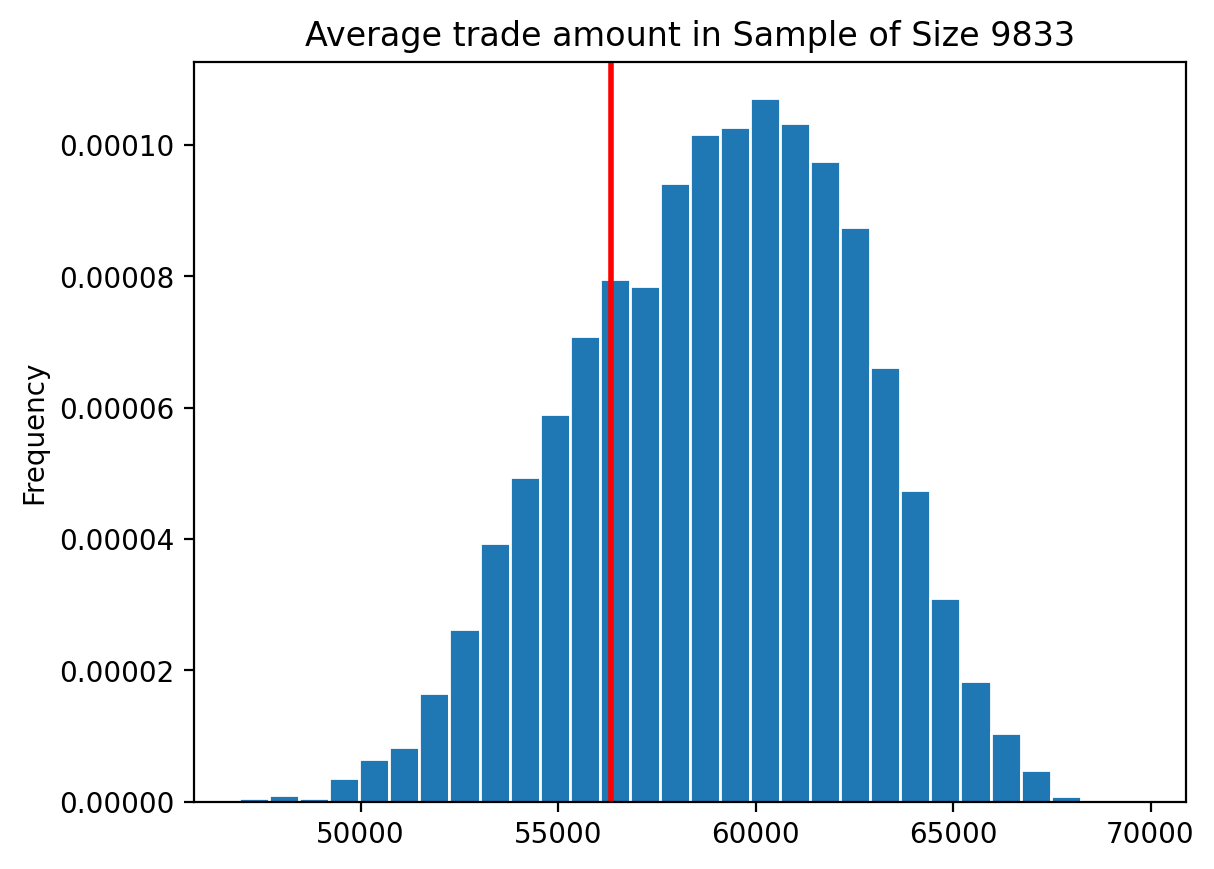

In [119]:
pd.Series(averages).plot(kind='hist', 
                         density=True,
                         bins=30,
                         ec='w',
                         title='Average trade amount in Sample of Size 9833');
plt.axvline(x=obs_de_amount, color='red', linewidth=2);